# knn

In [ ]:
- 데이터 분포에 대한 특정한 가정 하지 않음
- 새로운 관찰을 K의 가장 유사한 인스턴스와 비교하는 것을 기반으로 함

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pandas_datareader import data
from sklearn.model_selection import train_test_split

In [25]:
def load_financial_data(start_date, end_date, output_file):
    df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    return df

In [26]:
goog_data=load_financial_data(start_date='2001-01-01', end_date='2021-01-01', output_file='goog_data_large.pkl')

In [27]:
def create_trading_condition(df):
    df['Open-Close']=df.Open-df.Close
    df['High-Low']=df.High-df.Low
    df=df.dropna()
    X=df[['Open-Close','High-Low']]
    Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)
    return (X,Y)

In [28]:
X,Y=create_trading_condition(goog_data) # 전략 롱포지션(+1)과 숏 포지션(-1)을 취하는 규칙 만든다

In [29]:
def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

In [30]:
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [31]:
knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

In [32]:
goog_data['Predicted_Signal']=knn.predict(X)

In [33]:
def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

In [34]:
def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [35]:
goog_data['Predicted_Signal']=knn.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))

In [36]:
def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

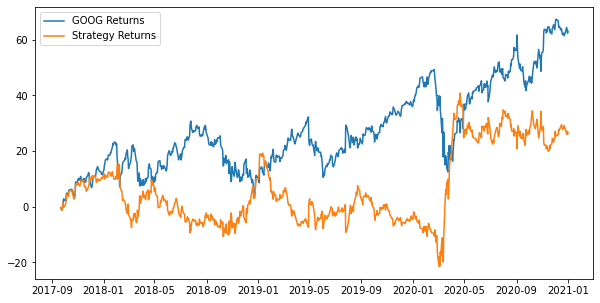

In [37]:
plot_chart(cum_goog_return, cum_strategy_return, symbol='GOOG')